In [3]:
#I aligned and clipped the sequences at the end using clustalo with 3 iterations
#it looks like some of the N and C terminal weren't shared across all homologues so I just kept the core

import subprocess
import shlex

In [4]:

import pandas as pd
import csb

In [5]:


def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ''):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.hhm'
        args += ' -ohhm ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]


def runHHmake( aln , name, path = 'hhmake' , outdir='./', verbose = False, SS = False):
    if verbose == True:
        print( [aln , name, path , outdir] )
    outhhm= outdir+name+".hhm"
    args = path + ' -i '+  aln  +' -o '+ outhhm + ' -M 50'
    if SS == True:
        #todo : make ss prediction here
        pass
    args = shlex.split(args)
    print(args)
    p = subprocess.Popen(args )
    return p , [outhhm]

    

def hhrparse(hhr , coverage , proba ):
    profile = HHOutputParser(alignments=False).parse_file(hhr)
    qname = profile.query_name
    for hit in profile:
        proba = hit.probability
        i = hit.id

In [6]:
#lets search for new homologues with hhblits
import time
t0 = time.time()
structaln ='./pad1/pad1_allseqs.clip.aln.fasta'
p, output = runHHmake( structaln , 'pad1' , path = 'hhmake' , outdir='./pad1/', verbose = False, SS = False)
uniclust = '/home/cactuskid13/mntpt/HHBLITsdb/uniclust30_2018_08/uniclust30_2018_08'
p , output = runHHblits( output[0] , name = 'structaln' , path= 'hhblits ' , outdir = './pad1/' , db = uniclust , iterations= 3 , ncores = 8 , verbose = True , runName= 'findPad1'  , xargs = ' -mact .5 ')
print( time.time() - t0)

['hhmake', '-i', './pad1/pad1_allseqs.clip.aln.fasta', '-o', './pad1/pad1.hhm', '-M', '50']
['./pad1/pad1.hhm', 'structaln', 'hhblits ', './pad1/', '/home/cactuskid13/mntpt/HHBLITsdb/uniclust30_2018_08/uniclust30_2018_08', 3, 8, 'findPad1']
hhblits  -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/uniclust30_2018_08/uniclust30_2018_08 -i ./pad1/pad1.hhm -o ./pad1/structalnfindPad1.hhr -n 3 -B 2000 -Z 2000  -mact .5 
192.52296042442322


In [7]:
#parse the output
from csb.bio.io.hhpred import HHOutputParser
newhits = {}
results = HHOutputParser(alignments=False).parse_file('./pad1/structalnfindPad1.hhr')
for hit in results:
    newhits.update( { hit.id.split('|')[1].strip() : { 'prob':hit.probability, 'len' : hit.length }}  )
                                                      


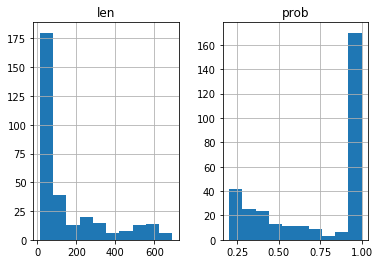

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


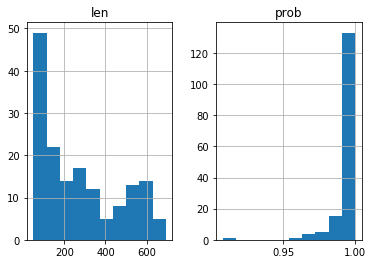

             prob  len
A0A017SVG3  1.000  557
A0A060WJ58  1.000  524
A0A086GS37  0.983   54
A0A091EAK8  0.989   88
A0A093Q481  1.000  639
A0A096PF24  1.000  302
A0A0A2VVP3  0.975   85
A0A0A2VWB7  0.993   78
A0A0B2WNI0  0.986   77
A0A0B2WPC9  0.999  179
A0A0B2WRB1  1.000  348
A0A0B4G4U8  1.000  589
A0A0B4HXI8  0.995   96
A0A0B4I157  0.999  136
A0A0B4XM96  1.000  690
A0A0B5HML2  0.975   98
A0A0D2YDZ6  1.000  524
A0A0D2YJL6  1.000  591
A0A0F3IDX3  0.994  188
A0A0F3IF51  0.999  291
A0A0F3IF79  1.000  355
A0A0F3IHQ1  0.998  245
A0A0F3IIY0  0.998  131
A0A0F7FW87  0.998  236
A0A0F7ZSX7  0.995   63
A0A0F8A3N4  0.997  115
A0A0F8AWD8  1.000  220
A0A0J9WAD0  1.000  591
A0A0K8PHK1  0.995  122
A0A0M8XAJ5  0.995  133
...           ...  ...
F6Y0Y5      1.000  503
F6YHU3      1.000  126
F7D1N6      1.000  317
F7G020      1.000  275
G3IJW1      1.000  302
G9KEZ6      0.993  125
H8MV74      0.967   94
H9G9F0      1.000  341
H9GVN4      0.999  206
J4KM39      0.998   82
K6VQ14      1.000  577
K6VRD2     

In [8]:
#plot the scores and lengths of hits

from matplotlib import pyplot as plt
newhitsdf = pd.DataFrame.from_dict(newhits, orient= 'index')
newhitsdf.hist()
plt.show()

#filter out the crap
filterdf = newhitsdf[newhitsdf.prob >.9]
filterdf = filterdf[newhitsdf.len >50]

filterdf.hist()
plt.show()


print(filterdf)

In [9]:
import bioservices
#lets pull all the new hits from uniprot
uni = bioservices.uniprot.UniProt()
df = uni.get_df( filterdf.index )

In [10]:
#we can assign an HHblits score to each hit
#adhoc score = len * proba
df = df.merge( filterdf , how = 'left' , left_on = 'Entry' , right_index = True )
df['score'] = df['prob'] * df['len']
#sort the DF and print
print(df.sort_values( 'score' , ascending = False) )
df.to_csv( './pad1/pad1_hhblits_results.csv' )


          Entry        Entry name             Gene names  \
52   A0A167DYD6  A0A167DYD6_9HYPO            [ISF_09673]   
49   A0A0B4XM96  A0A0B4XM96_9GAMM            [S7S_15060]   
76   A0A2E4LSX2  A0A2E4LSX2_9PROT          [CMO07_01315]   
126  A0A2S5Q4E2  A0A2S5Q4E2_9GAMM          [CTY16_16955]   
90   A0A093Q481  A0A093Q481_9PASS           [N305_05200]   
5    A0A0Q3T7D7  A0A0Q3T7D7_AMAAE          [AAES_133547]   
104  A0A2H4SWK0  A0A2H4SWK0_CORMI         [A9K55_000323]   
64   A0A2S0WPR6  A0A2S0WPR6_9ACTN          [C3E78_14475]   
19       K6VRD2      K6VRD2_9MICO       [AUCHE_22_00890]   
116  A0A151GVC1  A0A151GVC1_9HYPO            [DCS_02161]   
69   A0A2U4A145  A0A2U4A145_TURTR         [LOC101321837]   
96   A0A0D2YJL6  A0A0D2YJL6_FUSO4                     []   
124  A0A0J9WAD0  A0A0J9WAD0_FUSO4           [FOXG_16731]   
107  A0A0B4G4U8  A0A0B4G4U8_METGA            [MGU_11025]   
101      Q2HCQ6      Q2HCQ6_CHAGB           [CHGG_01998]   
72       T0NST6      T0NST6_CAMFR       

In [11]:
print(list(df.Organism))

['Canis lupus familiaris (Dog) (Canis familiaris)', 'Paracoccidioides brasiliensis', 'Ornithorhynchus anatinus (Duckbill platypus)', 'Metarhizium acridum (strain CQMa 102)', 'Metarhizium acridum (strain CQMa 102)', 'Amazona aestiva (Blue-fronted Amazon parrot)', 'Ornithorhynchus anatinus (Duckbill platypus)', 'Cricetulus griseus (Chinese hamster) (Cricetulus barabensis griseus)', 'Actinomyces liubingyangii', 'Ornithorhynchus anatinus (Duckbill platypus)', 'Homo sapiens (Human)', 'Metarhizium acridum (strain CQMa 102)', 'Halobacteriovoraceae bacterium', 'Beauveria bassiana (White muscardine disease fungus) (Tritirachium shiotae)', 'Austwickia chelonae NBRC 105200', 'Verticillium alfalfae (strain VaMs.102 / ATCC MYA-4576 / FGSC 10136) (Verticillium wilt of alfalfa) (Verticillium albo-atrum)', 'Beauveria bassiana (White muscardine disease fungus) (Tritirachium shiotae)', 'Fusarium oxysporum f. sp. lycopersici (strain 4287 / CBS 123668 / FGSC 9935 / NRRL 34936) (Fusarium vascular wilt of t

In [12]:
genomes =[ int(g) for g in list( df['Organism ID'].dropna() ) ]
print(genomes)

[9615, 121759, 9258, 655827, 655827, 12930, 9258, 10029, 1921764, 9258, 9606, 655827, 2026745, 176275, 1184607, 526221, 176275, 426428, 102129, 1184607, 1387353, 1192034, 215803, 1344416, 1460502, 1447883, 2026799, 118168, 591159, 1905359, 2033, 146537, 345341, 1973928, 1973912, 860235, 1632867, 1632867, 1632867, 38654, 28377, 1081103, 33203, 225400, 9940, 9258, 391936, 10224, 94208, 1081104, 1658174, 339724, 332952, 1245745, 2038116, 1666905, 362257, 1396, 1069642, 1797899, 67267, 2079793, 2013748, 1797268, 313612, 9739, 9739, 419612, 9669, 419612, 2022490, 1276136, 94208, 1912094, 46177, 8665, 1777136, 1797896, 56216, 412755, 1852927, 1671698, 2013748, 1933779, 1415549, 215358, 299123, 328815, 215803, 1380566, 1043627, 2004951, 1089457, 426428, 1276136, 8400, 8400, 28377, 306901, 9258, 9258, 73501, 655819, 1524831, 1276136, 1245745, 1632867, 39478, 176275, 1237896, 1622148, 1380566, 2013829, 98403, 408015, 2004952, 703756, 1316194, 960, 392333, 1632867, 426428, 1081103, 2051955, 4057

In [17]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

tree = ncbi.get_topology(genomes, intermediate_nodes=False)
print( tree.get_ascii(attributes=["sci_name"] ))





                                                                        /-Nostoc flagelliforme CCNUN1
                                                              /Nostocales
                                                             |          \-Calothrix sp. NIES-4071
                                                             |
                                                             |                               /-Lyngbya sp. PCC 8106
                                                             |               /Oscillatoriaceae
                                                 /Cyanobacteria             |                \-Phormidium sp. OSCR
                                                |            |-Oscillatoriales
                                                |            |              |--Hydrocoleum sp. CS-953
                                                |            |              |
                                                |            |               